# Week 2 Problem 1

A few things you should keep in mind when working on assignments:

1. Make sure you fill in any place that says `YOUR CODE HERE`. Do not write your answer in anywhere else other than where it says `YOUR CODE HERE`. Anything you write anywhere else will be removed or overwritten by the autograder.

2. Before you submit your assignment, make sure everything runs as expected. Go to menubar, select *Kernel*, and restart the kernel and run all cells (*Restart & Run all*).

3. Do not change the title (i.e. file name) of this notebook.

4. Make sure that you save your work (in the menubar, select *File* → *Save and CheckPoint*)

5. When you are ready to submit your assignment, go to *Dashboard* → *Assignments* and click the *Submit* button. Your work is not submitted until you click *Submit*.

6. You are allowed to submit an assignment multiple times, but only the most recent submission will be graded.

# Due Date: 6 PM, January 29, 2018

In [1]:
% matplotlib inline
import os
import math
import numpy as np
import seaborn as sns
from nose.tools import assert_equal, assert_true
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_breast_cancer
# We do this to ignore several specific warnings
import warnings
warnings.filterwarnings("ignore")

# Convenience function to plot confusion matrix

# This method produces a colored heatmap that displays the relationship
# between predicted and actual types from a machine leanring method.

def confusion(test, predict, names, bins=3, title='Confusion Matrix'):

    # Make a 2D histogram from the test and result arrays
    pts, xe, ye = np.histogram2d(test, predict, bins)

    # For simplicity we create a new DataFrame
    pd_pts = pd.DataFrame(pts.astype(int), index=names, columns=names )
    
    # Display heatmap and add decorations
    sns.set(font_scale=1.5)
    hm = sns.heatmap(pd_pts, annot=True, fmt="d")
    
    sns.set(font_scale=2.0)
    hm.axes.set_title(title)
    hm.axes.set_xlabel('Predicted')
    hm.axes.set_ylabel('Actual')
    sns.set(font_scale=1.0)

    return None

## Breast Cancer Dataset
For this assignment we will be using the built-in dataset about breast cancer and the respective information on indivudal breast cancer cases. This dataset has 569 samples and a dimensionality size of 30. In this assignment, we will be using the various attributes and Logistic Regression in order to create a model that will predict whether the individual case is either malignant (harmful) or benign (non-harmful). Throughout the assignment, we will be improving our model from one that is very naïve to a more complicated one that accounts for all the attributes in the given dataset. 

The following code below imports the dataset as a pandas dataframe and previews a few sample data points. It also concatenates a column called classification which contains whether the record was determined to be a malignant or benign tumor. **Note: In this dataset, a malignant tumor has a value of 0 and a benign tumor has a value of 1**

In [2]:
'''
NOTE: Make sure to load this data set before completing the assignment
'''
# Load in the dataset as a Pandas DataFrame
data = load_breast_cancer()
data_df = pd.DataFrame(data.data, columns=data.feature_names)

# Preview the first few lines
data_df['classification'] = data.target
data_df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,classification
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


## Question 1 - Naïve Implementation

One very simple way to use binnarize records is to use a pre-determined cutoff value for a particular feature and classify anything less than a cutoff value as 0 and anything over the cutoff value as 1. The pre-determined cutoff value can be determined through other statistical methods to be general enough in order to correctly classify some instances of the data. However, it is very clear that this approach will not work for all cases and is very rudimentary. In the question below, complete the function `classify_cutoff` that takes in 3 parameters: `data_df` (the dataframe), `column_name` and `cutoff` and create a new column called `classification_simple` that contains either a 0 or 1 based on the cutoff value and the column name. If the column for that particular record is **less** than the cutoff value, then record a 0 in the `classification_simple` column; otherwise record a 1. 

For example, given the random 5 data points in the above code cell, if the `column_name` was mean radius and the `cutoff` was 12, then the 1st, 2nd, and 4th records would contain a 1 in the `classification_simple` column since the mean radius of these records are all greater than 12, and the 3rd and 5th records would be 0.

In [10]:
data_df.iloc[0]['mean radius']

17.989999999999998

In [30]:
def classify_cutoff(data_df, column_name, cutoff):
    '''
    Converts one column in Pandas.DataFrame data_df into binary
    as a new column, and returns the new DataFrame (dat_df plus new binary column).
    
    Parameters
    ----------
    data_df: A Pandas.DataFrame.
    column: A string.
    cutoff: An int.
    
    Returns
    -------
    A Pandas.DataFrame.
    '''
    #define a new empty list
    classification_simple = []
    
    #the index of loop should from 0 to the number of instances
    for i in range(0, 569):
        
        ##assign a list should use append
        if data_df.iloc[i][column_name] < cutoff:
            classification_simple.append(0)
        else:
            classification_simple.append(1)
    
    #add the list to the existing dataframe
    data_df['classification_simple'] = classification_simple
    
    return data_df
        

In [31]:
assert_true(isinstance(classify_cutoff(data_df, 'mean radius', 2), pd.DataFrame))
assert_true('classification_simple' in classify_cutoff(data_df, 'mean radius', 2))

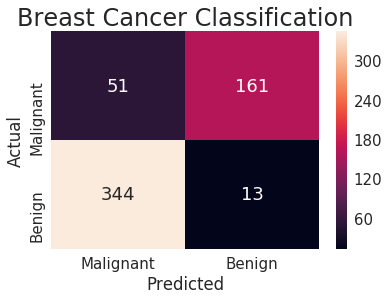

In [32]:
# Generate the Confusion Matrix for the classify_cutoff (naïve implementation)
# Should have a lot of Type I and Type II errors
# We shall now use our Logistic Regression Models to reduce these errors

new_data_df = classify_cutoff(data_df, 'mean radius', 15)
confusion(new_data_df['classification'], 
             new_data_df['classification_simple'], ['Malignant', 'Benign'], 2, 'Breast Cancer Classification')

## Question 2 - SGD Classifier

In this question, we will be improving upon our very naïve implementation from earlier by actually using Logistic Regression. One way that you have learned to do this is through Stochastic Gradient Descent (SGD) that minimizes the loss function. Complete the following function below to use the `SGDClassifier` constructor using 'log' as the value to the loss parameter to the contructor. Here are the function specifications:

- 'log' as the value to the loss parameter to the SGDClassifier constructor
- use the `train_test_split` method to split the features and labels parameters into testing and training data
- use a value of 23 for the random state
- use the labels as the stratify parameter
- use a test size of 0.3 into the `train_test_split` method
- return the predicted values after the `predict()` function runs and the dependent test data from the `train_test_split` function as a 2-tuple

In [34]:
def sgd_classifier(features, labels):
    '''
    Return the predicted data using the SGDClassifier technique
    
    Parameters
    ----------
    features: A Pandas dataframe representing the features data
    labels: A Pandas dataframe represengint the labels data
    
    Returns
    -------
    predicted, y_test: A 2-tuple consisting of 2 respective numpy arrays
        - predicted is the result of the predict() function
        - y_test is the data that can be used to check how accurate the model was
    '''
    
    model = LogisticRegression(C=1E6)
    
    # Create SGD estimor with log loss
    sgd_model = SGDClassifier(loss='log')
    
    #spit the data into training and testing data
    # Evaluate the model by splitting into train and test sets
    x_train, x_test, y_train, y_test = train_test_split(features, labels, 
                                                         test_size=0.3, 
                                                         stratify = labels,
                                                         random_state=23)

    # Fit training data and predict for test data
    sgd_model = model.fit(x_train, y_train)
    predicted = sgd_model.predict(x_test)
    
    return predicted, y_test

In [35]:
assert_true(isinstance(sgd_classifier(data.data, data.target)[0], np.ndarray))
assert_true(isinstance(sgd_classifier(data.data, data.target)[1], np.ndarray))
assert_equal(len(sgd_classifier(data.data, data.target)[0]), int(math.ceil(len(data.data)*0.3)))

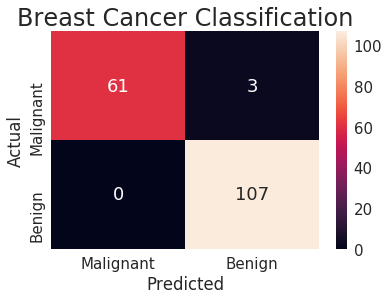

In [36]:
# Generate the Confusion Matrix using the SGD Classifier
# Should have drastically reduced the number of Type I and Type II errors from our naïve implementation

predicted, y_test = sgd_classifier(data.data, data.target)
confusion(y_test.reshape(y_test.shape[0]), predicted, ['Malignant', 'Benign'], 2, 'Breast Cancer Classification')

## Question 3 - LogisticRegression

In this question, we will be using the standard LogisticRegression constructor to perform logistic regression instead of explicitly using the SGD Classifier. Complete the following function below to use the `LogisticRegression` constructor. Here are the function specifications:

- use the `train_test_split` method to split the features and labels parameters into testing and training data
- use a value of 23 for the random state
- use the labels as the stratify parameter
- use a test size of 0.3 into the `train_test_split` method
- return the predicted values after the `predict()` function runs and the dependent test data from the `train_test_split` function as a 2-tuple

In [39]:
def logistic_regression(features, labels):
    '''
    Return the predicted data using the LogisticRegression technique technique
    
    Parameters
    ----------
    features: A Pandas dataframe representing the features data
    labels: A Pandas dataframe represengint the labels data
    
    Returns
    -------
    predicted, y_test: A 2-tuple consisting of 2 respective numpy arrays
        - predicted is the result of the predict() function
        - y_test is the data that can be used to check how accurate the model was
    '''
    model = LogisticRegression(C=1E6)
    
    # Evaluate the model by splitting into train and test sets
    x_train, x_test, y_train, y_test = train_test_split(features, labels, 
                                                        test_size=0.3, 
                                                        stratify = labels,
                                                        random_state=23)

    # Fit a new model and predict on test data
    lr_model = model.fit(x_train, y_train)
    predicted = lr_model.predict(x_test)
    
    return predicted, y_test

In [40]:
assert_true(isinstance(logistic_regression(data.data, data.target)[0], np.ndarray))
assert_true(isinstance(logistic_regression(data.data, data.target)[1], np.ndarray))
assert_equal(len(logistic_regression(data.data, data.target)[0]), int(math.ceil(len(data.data)*0.3)))

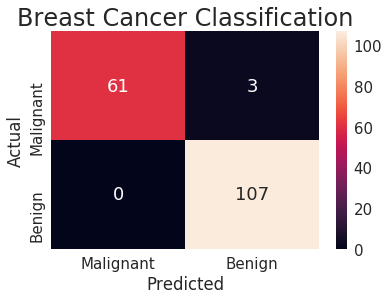

In [41]:
# Generate the Confusion Matrix using the Logistic Regression Method
# We should achieve very similar statistics to our SGDClassifier model

predicted, y_test = logistic_regression(data.data, data.target)
confusion(y_test.reshape(y_test.shape[0]), predicted, ['Malignant', 'Benign'], 2, 'Breast Cancer Classification')